Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total usable images: 372
Epoch 01/20 | Train Loss: 0.4657, Acc: 0.8013 | Val Loss: 0.4871, Acc: 0.8267
Epoch 02/20 | Train Loss: 0.4006, Acc: 0.8350 | Val Loss: 0.3848, Acc: 0.8400
Epoch 03/20 | Train Loss: 0.3882, Acc: 0.8485 | Val Loss: 0.4819, Acc: 0.8400
Epoch 04/20 | Train Loss: 0.3819, Acc: 0.8283 | Val Loss: 0.5185, Acc: 0.8400
Epoch 05/20 | Train Loss: 0.3999, Acc: 0.8384 | Val Loss: 0.4006, Acc: 0.8400
Epoch 06/20 | Train Loss: 0.3765, Acc: 0.8384 | Val Loss: 0.4487, Acc: 0.7733
Epoch 07/20 | Train Loss: 0.3943, Acc: 0.8384 | Val Loss: 0.3974, Acc: 0.8400
Epoch 08/20 | Train Loss: 0.3614, Acc: 0.8384 | Val Loss: 0.3827, Acc: 0.8667
Epoch 09/20 | Train Loss: 0.3468, Acc: 0.8350 | Val Loss: 0.4120, Acc: 0.8667
Epoch 10/20 | Train Loss: 0.3695, Acc: 0.8620 | Val Loss: 0.4490, Acc: 0.8667
Epoch 11/20 | Train Loss: 0.3621, Acc: 0.8485 | Val Loss: 0.3826, 

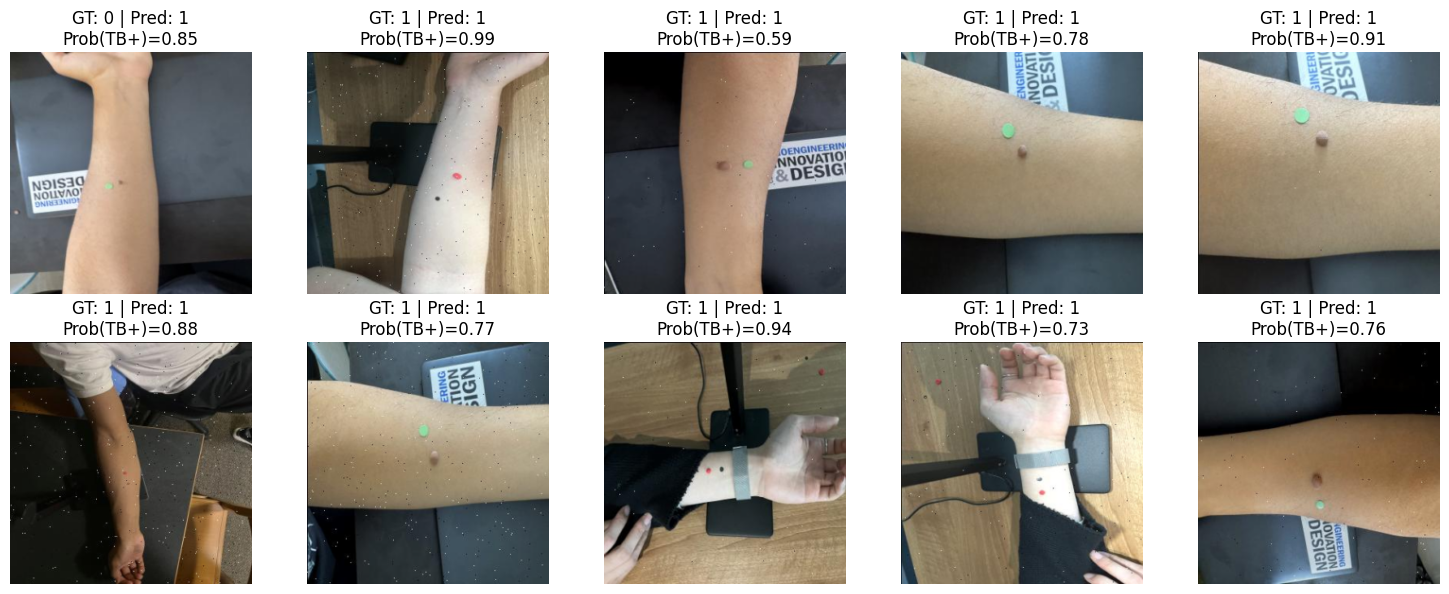


Saved model weights to: /content/drive/MyDrive/CV Pictures/data372/tb_unet_classifier_weights.pth


In [ ]:
import os
from google.colab import drive

import json
import math
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/CV Pictures/data372')


# =========================
# Dataset that reads COCO
# =========================

class COCOTSTDataset(Dataset):
    """
    Dataset for Tuberculin Skin Test (TST) based on COCO annotations.

    Assumes:
        - category_id == 1: induration
        - category_id == 2: sticker (calibration marker)
        - physical sticker diameter = 6 mm

    For each image:
        1. Find sticker bbox -> estimate sticker diameter in pixels.
        2. Compute mm_per_px = 6.0 / sticker_px.
        3. Find induration area/bbox -> estimate diameter in pixels.
        4. Convert to mm and assign label:
            label = 1 if diameter_mm >= threshold_mm else 0
    """
    def __init__(
        self,
        coco_json_path,
        image_root,
        ind_cat_id=1,
        sticker_cat_id=2,
        threshold_mm=5.0,
        use_area=True,
        transform=None,
    ):
        with open(coco_json_path, "r") as f:
            coco = json.load(f)

        self.image_root = image_root
        self.threshold_mm = threshold_mm

        images = {img["id"]: img for img in coco["images"]}
        annos_by_img = defaultdict(list)
        for a in coco["annotations"]:
            annos_by_img[a["image_id"]].append(a)

        self.samples = []
        for img_id, img in images.items():
            annos = annos_by_img.get(img_id, [])

            sticker = None
            induration = None
            for a in annos:
                if a["category_id"] == sticker_cat_id:
                    sticker = a
                elif a["category_id"] == ind_cat_id:
                    induration = a

            # Skip if missing either annotation
            if sticker is None or induration is None:
                continue

            # --- Sticker diameter in pixels (average of bbox w/h) ---
            sx, sy, sw, sh = sticker["bbox"]
            sticker_px = (sw + sh) / 2.0
            if sticker_px <= 0:
                continue

            mm_per_px = 6.0 / sticker_px  # 6 mm calibration marker

            # --- Induration diameter in pixels ---
            if use_area and induration.get("area", 0) > 0:
                A = float(induration["area"])
                ind_px = 2.0 * math.sqrt(A / math.pi)  # equivalent circle
            else:
                bx, by, bw, bh = induration["bbox"]
                ind_px = max(bw, bh)

            diameter_mm = ind_px * mm_per_px
            label = 1.0 if diameter_mm >= threshold_mm else 0.0

            self.samples.append(
                {
                    "image_path": os.path.join(image_root, img["file_name"]),
                    "diameter_mm": diameter_mm,
                    "label": label,
                }
            )

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        img = Image.open(s["image_path"]).convert("RGB")
        x = self.transform(img)
        y = torch.tensor(s["label"], dtype=torch.float32)
        return x, y


# =========================
# U-Net backbone (encoder) + classifier head
# =========================

class DoubleConv(nn.Module):
    """(Conv2d -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.net(x)


class UNetClassifier(nn.Module):
    """
    U-Net encoder used as a feature extractor + global pooling + FC for
    binary classification (TB present if induration >= 5mm).
    """
    def __init__(self, n_channels=3):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, 1)

    def forward(self, x):
        x1 = self.inc(x)      # 64
        x2 = self.down1(x1)   # 128
        x3 = self.down2(x2)   # 256
        x4 = self.down3(x3)   # 512
        x5 = self.down4(x4)   # 1024 (bottleneck)

        pooled = self.global_pool(x5)      # [B, 1024, 1, 1]
        pooled = pooled.view(pooled.size(0), -1)  # [B, 1024]
        logits = self.fc(pooled)           # [B, 1]
        return logits.squeeze(1)           # [B]


# =========================
# Training / evaluation
# =========================

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


# =========================
# Main
# =========================

def main():

    COCO_JSON = "train/_annotations.coco.json"  # path to your COCO file
    IMAGE_ROOT = "train"                 # folder containing the image files

    batch_size = 8
    num_epochs = 20
    lr = 1e-3
    val_split = 0.2     # 80/20 split
    threshold_mm = 5.0  # TB positive if diameter >= 5mm

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = COCOTSTDataset(
        coco_json_path=COCO_JSON,
        image_root=IMAGE_ROOT,
        threshold_mm=threshold_mm,
        use_area=True,
    )

    print(f"Total usable images: {len(dataset)}")

    # Extract labels for stratified split
    labels = [s["label"] for s in dataset.samples]
    indices = list(range(len(dataset)))

    train_idx, val_idx = train_test_split(
        indices,
        test_size=val_split,
        random_state=42,
        stratify=labels
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=4, pin_memory=True)

    model = UNetClassifier(n_channels=3).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )
        val_loss, val_acc = eval_one_epoch(
            model, val_loader, criterion, device
        )

        print(
            f"Epoch {epoch:02d}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
        )



    # =========================
    # Final Accuracy (CIFAR-style)
    # =========================

    '''
    print("\nEvaluating final model accuracy...")

    test_loader = DataLoader(dataset, batch_size=256, shuffle=False)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs)

        # Convert logits → probabilities → predicted class (0 or 1)
        probs = torch.sigmoid(logits)
        predicted = (probs >= 0.5).float()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"\nFinal Model Accuracy: {correct / total:.4f}")
    '''


    # -------------------------
    # CIFAR-style final accuracy
    # -------------------------

    print("\nEvaluating final model accuracy...")

    test_loader = DataLoader(dataset, batch_size=256, shuffle=False)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            probs = torch.sigmoid(logits)
            predicted = (probs >= 0.5).float()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"\nFinal Model Accuracy: {correct / total:.4f}")

    # -------------------------
    # Visualize 10 random images
    # with predicted TB label
    # -------------------------
    import random
    import matplotlib.pyplot as plt

    # helper to "undo" normalization for display
    def denorm(img_tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return img_tensor * std + mean

    model.eval()
    num_to_show = min(10, len(dataset))
    rand_indices = random.sample(range(len(dataset)), num_to_show)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(rand_indices):
        img_tensor, label = dataset[idx]        # normalized tensor + GT label
        img_input = img_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            logit = model(img_input)
            prob = torch.sigmoid(logit).item()
            pred_label = 1.0 if prob >= 0.5 else 0.0

        # prepare image for plotting
        img_vis = denorm(img_tensor).clamp(0, 1).cpu()
        img_vis = img_vis.permute(1, 2, 0).numpy()  # CHW -> HWC

        plt.subplot(2, 5, i + 1)
        plt.imshow(img_vis)
        plt.axis("off")
        plt.title(
            f"GT: {int(label.item())} | Pred: {int(pred_label)}\nProb(TB+)={prob:.2f}"
        )

    plt.tight_layout()
    plt.show()


    # ... after training loop and final accuracy ...

    # -------------------------
    # Save final weights to .pth
    # -------------------------
    weights_path = "tb_unet_classifier_weights.pth"
    torch.save(model.state_dict(), weights_path)
    print(f"\nSaved model weights to: {os.path.abspath(weights_path)}")





if __name__ == "__main__":
    main()


In [ ]:
model = UNetClassifier(n_channels=3)
state_dict = torch.load("tb_unet_classifier_weights.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()


UNetClassifier(
  (inc): DoubleConv(
    (net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (net): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (net): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=